In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error

In [132]:
df=pd.read_csv(r"data\housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [133]:
df.drop(["ocean_proximity","longitude","latitude"],axis=1).corr()
# total_bedrooms, total_rooms
# population, households 
# total_room, households


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
housing_median_age,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [134]:
df["bedroom_per_room"]=df["total_bedrooms"]/df["total_rooms"]
df["populatin_per_household"]=df["population"]/df["households"]
df["room_per_households"]=df["total_rooms"]/df["households"]

In [135]:
df[["housing_median_age","median_income","median_house_value","bedroom_per_room","populatin_per_household","room_per_households"]].corr()

,housing_median_age,median_income,median_house_value,bedroom_per_room,populatin_per_household,room_per_households
housing_median_age,1.000000,-0.119034,0.105623,0.136089,0.013191,-0.153277
median_income,-0.119034,1.000000,0.688075,-0.615661,0.018766,0.326895
median_house_value,0.105623,0.688075,1.000000,-0.255880,-0.023737,0.151948
bedroom_per_room,0.136089,-0.615661,-0.255880,1.000000,0.002938,-0.416952
populatin_per_household,0.013191,0.018766,-0.023737,0.002938,1.000000,-0.004852
room_per_households,-0.153277,0.326895,0.151948,-0.416952,-0.004852,1.000000


In [136]:
num_feture=["housing_median_age","median_income","bedroom_per_room","populatin_per_household","room_per_households"]
cat_feature=["ocean_proximity"]

In [137]:
x=df.drop("median_house_value",axis=1)
y=df["median_house_value"]

In [138]:
num_pipeline=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])
cat_pipeline=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("onehot",OneHotEncoder(handle_unknown="ignore"))
])

processor=ColumnTransformer(transformers=[
    ("num",num_pipeline,num_feture),
    ("cat",cat_pipeline,cat_feature)
])
full_pipeline=Pipeline(steps=[
    ("process",processor),
    ("model",RandomForestRegressor(random_state=42))
])

In [ ]:
# Hyperparameter tuning
param_distributions = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [10, 20, 30, None],
    "model__max_features": ["sqrt", "log2"],
    "model__min_samples_split": [2, 5, 10]
}

random_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring="neg_mean_absolute_error",
    verbose=2,
    random_state=42,
    n_jobs=-1
)


In [140]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=42)
random_search.fit(x_train,y_train)
y_pred = random_search.predict(x_test)

# 9. Đánh giá mô hình
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE của Random Forest sau tuning: {mae:.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
MAE của Random Forest sau tuning: 41151.16


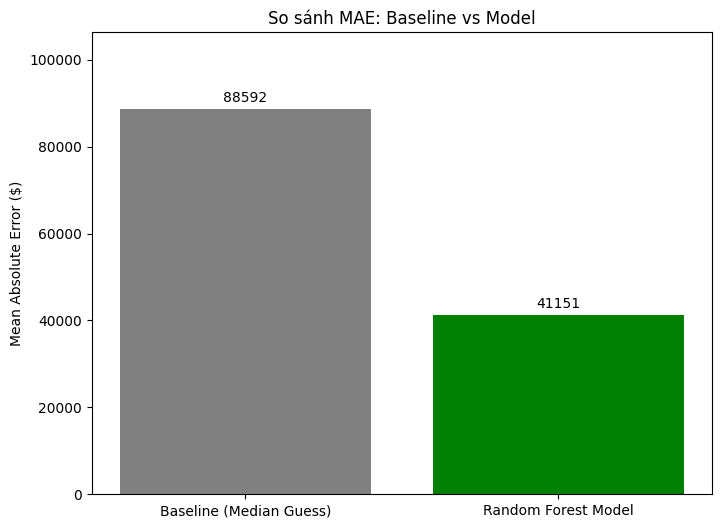

In [141]:
baseline_pred = np.full(shape=len(y_train), fill_value=y_train.median())
baseline_mae = mean_absolute_error(y_train, baseline_pred)

# 2. Model MAE: chính là MAE bạn tính bằng cross-validation
model_mae = mae  

# 3. Plot so sánh
labels = ['Baseline (Median Guess)', 'Random Forest Model']
mae_values = [baseline_mae, model_mae]

plt.figure(figsize=(8,6))
bars = plt.bar(labels, mae_values, color=['gray', 'green'])
plt.ylabel('Mean Absolute Error ($)')
plt.title('So sánh MAE: Baseline vs Model')

# Thêm số liệu trên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1000, f'{yval:.0f}', ha='center', va='bottom')

plt.ylim(0, max(mae_values)*1.2)
plt.show()